# ****Лабораторная работы №1****: *"Классификация Симпсонов"*

## ***Про сам Simpson competition на kaggle:***

#### Ссылка на competition: https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset

#### **Задача проста**: *дано 42 классов персонажей Симпсонов и нужно решить задачу классификации со значением метрики **accuracy >= 0.7***

## ***Про датасет и его загрузка***

#### *Датасет представлен структурой вида* **"Отдельная папка с фотографиями одноименного класса"**

In [19]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



dataset_path = "simpsons_dataset"
dataset = datasets.ImageFolder(dataset_path, transform=None)

classes = dataset.classes
class_cnt = len(classes)
print(f"Все классы в датасете: {classes}\n Всего классов: {class_cnt}")

Все классы в датасете: ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']
 Всего классов: 42


In [20]:
from torch.utils.data import random_split
import matplotlib.pyplot as plt


train_dataset = datasets.ImageFolder("simpsons_dataset", transform=train_transform)
test_dataset  = datasets.ImageFolder("simpsons_dataset", transform=test_transform)

train_size = int(0.75 * len(train_dataset))
test_size = len(train_dataset) - train_size

train_subset, _ = random_split(train_dataset, [train_size, test_size])
_, test_subset = random_split(test_dataset, [train_size, test_size])


train_loader = DataLoader(
    dataset=train_subset,
    batch_size=64,
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=64,
    shuffle=False,
    num_workers=4
)



#### примерчик из датасета:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


размеры тензора-изображения из датасета: torch.Size([3, 224, 224]), класс изображения: abraham_grampa_simpson


Text(0.5, 1.0, 'example img from dataset: abraham_grampa_simpson')

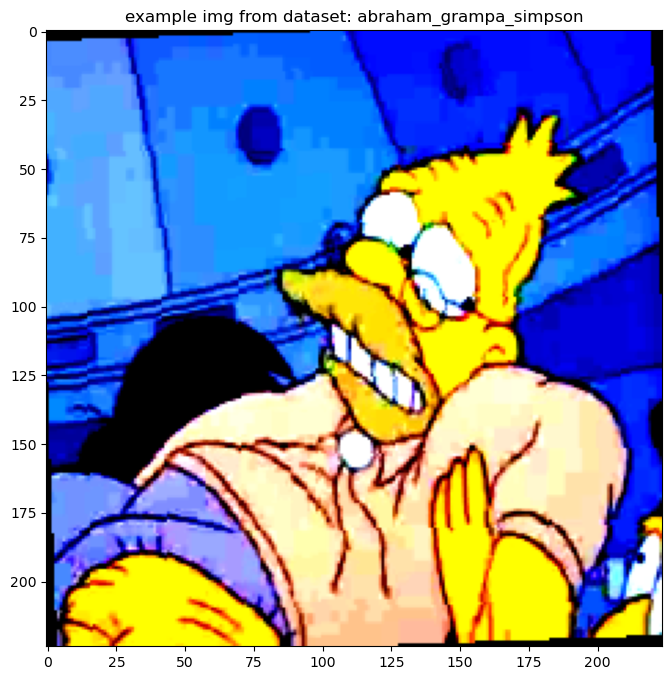

In [18]:
image, label = next(iter(train_dataset))
print(f"размеры тензора-изображения из датасета: {image.shape}, класс изображения: {classes[label]}")

img_fig = plt.figure(figsize=(12, 8))
plt.imshow(image.permute(1, 2, 0))
plt.title(f"example img from dataset: {classes[label]}")

## ***Модель:***

#### Стоит опробовать сравнительно простую и хорошую модель - **ResNet18**

In [26]:
from torchvision import models
from torchview import draw_graph

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

model_graph = draw_graph(
    model=model,
    input_data=torch.randn(1, 3, 224, 224),
    expand_nested=True
)

model_graph.visual_graph
print(model, device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## ***Обучение модели:***

In [10]:
from tqdm import tqdm
from torch import nn
from torch import optim

model.fc = nn.Linear(
    in_features=512,
    out_features=class_cnt,
    bias=True
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    params=model.parameters(),
    lr=0.01
)

model.to(device)

epochs = 30
for epoch in range(epochs):
    print(f"#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №{epoch + 1}-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#")
    
    model.train()
    
    train_loss, correct_cnt, total_batch_cnt = 0, 0, 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()

        
        _, predicted = torch.max(outputs.data, dim=1)
        total_batch_cnt += labels.size(dim=0)
        correct_cnt += (predicted == labels).sum().item()
        
    epoch_loss = train_loss / len(train_loader)
    epoch_acc = correct_cnt / total_batch_cnt
    print(f"Epoch №{epoch + 1}, loss={epoch_loss:.5f}, accuracy={epoch_acc:.5f}")


#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №1-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:50<00:00,  5.52it/s]


Epoch №1, loss=1.59513, accuracy=0.64733
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №2-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.79it/s]


Epoch №2, loss=0.61007, accuracy=0.86523
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №3-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.80it/s]


Epoch №3, loss=0.41963, accuracy=0.90614
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №4-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.72it/s]


Epoch №4, loss=0.32137, accuracy=0.92868
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №5-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.79it/s]


Epoch №5, loss=0.25739, accuracy=0.94296
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №6-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.80it/s]


Epoch №6, loss=0.21264, accuracy=0.95526
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №7-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:47<00:00,  5.81it/s]


Epoch №7, loss=0.17809, accuracy=0.96549
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №8-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.75it/s]


Epoch №8, loss=0.15331, accuracy=0.96847
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №9-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.77it/s]


Epoch №9, loss=0.13296, accuracy=0.97448
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №10-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:47<00:00,  5.82it/s]


Epoch №10, loss=0.11409, accuracy=0.97729
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №11-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:47<00:00,  5.85it/s]


Epoch №11, loss=0.10612, accuracy=0.98151
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №12-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:47<00:00,  5.84it/s]


Epoch №12, loss=0.09361, accuracy=0.98280
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №13-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:47<00:00,  5.84it/s]


Epoch №13, loss=0.08323, accuracy=0.98629
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №14-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.81it/s]


Epoch №14, loss=0.07471, accuracy=0.98837
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №15-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:47<00:00,  5.82it/s]


Epoch №15, loss=0.06776, accuracy=0.98938
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №16-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:47<00:00,  5.85it/s]


Epoch №16, loss=0.06134, accuracy=0.99090
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №17-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:47<00:00,  5.82it/s]


Epoch №17, loss=0.05714, accuracy=0.99185
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №18-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.81it/s]


Epoch №18, loss=0.05344, accuracy=0.99241
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №19-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.80it/s]


Epoch №19, loss=0.05042, accuracy=0.99348
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №20-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.79it/s]


Epoch №20, loss=0.05032, accuracy=0.99331
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №21-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.77it/s]


Epoch №21, loss=0.04211, accuracy=0.99432
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №22-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.79it/s]


Epoch №22, loss=0.03790, accuracy=0.99545
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №23-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.79it/s]


Epoch №23, loss=0.03790, accuracy=0.99562
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №24-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.78it/s]


Epoch №24, loss=0.03661, accuracy=0.99562
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №25-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.79it/s]


Epoch №25, loss=0.02750, accuracy=0.99629
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №26-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:48<00:00,  5.74it/s]


Epoch №26, loss=0.03722, accuracy=0.99635
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №27-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:49<00:00,  5.65it/s]


Epoch №27, loss=0.03159, accuracy=0.99713
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №28-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:49<00:00,  5.63it/s]


Epoch №28, loss=0.02996, accuracy=0.99708
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №29-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:49<00:00,  5.64it/s]


Epoch №29, loss=0.02573, accuracy=0.99770
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-Epoch №30-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#


100%|██████████| 279/279 [00:49<00:00,  5.64it/s]

Epoch №30, loss=0.02404, accuracy=0.99753


### *Сохраним параметры модели*

In [11]:
model_path = "best_model.pth"
torch.save(model.state_dict(), model_path)

### *Загрузим параметры модели перед eval*

In [22]:
best_model = models.resnet18()
best_model.fc = nn.Linear(
    in_features=512,
    out_features=class_cnt,
    bias=True
)

best_model.load_state_dict(torch.load("best_model.pth", map_location=device))
best_model = best_model.to(device)

C:\Users\Администратор\AppData\Local\Temp\ipykernel_17092\1498494994.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model.pt

## ***Проверка модели на test dataset***

In [23]:
test_loss, test_acc = 0, 0
total, correct = 0, 0

best_model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        test_loss += loss_fn(outputs, labels).item()
        
        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(dim=0)
        correct += (predicted == labels).sum().item()
        
    test_loss = test_loss / len(test_loader)
    test_acc = correct / total
    
print(f"ResNet18 за {epochs} эпох на test данных: Loss={test_loss:.5f}, Accuracy={test_acc:.5f}")

100%|██████████| 82/82 [00:20<00:00,  3.96it/s]

ResNet18 за 30 эпох на test данных: Loss=0.02489, Accuracy=0.99465
